In [1]:
%pylab inline


Populating the interactive namespace from numpy and matplotlib


In [2]:
# package loading, helper functions

import h5py
import numpy as np
import scipy.ndimage as ndi
import sklearn
import torch
#Source("digraph {X->Y; Y->Z;}")
from graphviz import Source
from scipy.stats import kde
from sklearn import decomposition
from torch import nn, optim

import imgclass
import imgimg
import layers

rc("image", cmap="gray", interpolation="nearest")


def T(a):
    if isinstance(a, ndarray):
        return torch.FloatTensor(a).cuda()
    else:
        return a


def Tim(a):
    assert isinstance(a, ndarray)
    if a.ndim == 3:
        a = np.expand_dims(a, 3)
    assert a.ndim == 4
    return torch.FloatTensor(a.transpose(0, 3, 1, 2)).cuda()


def Cl(a):
    return torch.LongTensor(a).cuda()


def Nim(a):
    a = a.cpu().detach().numpy()
    assert a.ndim == 4
    return a.transpose(0, 2, 3, 1)


def Fl(a):
    a = T(a)
    return a.reshape(a.size(0), -1)


def N(a):
    return a.cpu().detach().numpy()


def tshow(v, ax=None, **keys):
    if isinstance(v, torch.Tensor):
        v = v.cpu().detach().numpy()
    if v.ndim == 1:
        v = v.reshape(28, 28)
    if v.ndim == 3 and v.shape[0] == 1:
        v = v[0]
    if v.ndim == 3 and v.shape[2] == 1:
        v = v[:, :, 0]
    if v.ndim == 4:
        v = v[0, 0]
    v = v - amin(v)
    v /= amax(v)
    if ax is not None:
        ax.imshow(v, **keys)
    else:
        imshow(v, **keys)


def showrow(*args, **kw):
    figsize(*kw.get("fs", (15, 5)))
    if "fs" in kw:
        del kw["fs"]
    for i, im in enumerate(args):
        subplot(1, len(args), i+1)
        tshow(im, **kw)


def showgrid(images, rows=4, cols=4, cmap=cm.gray, size=(7, 7)):
    if size is not None:
        figsize(*size)
    for i in range(rows*cols):
        subplot(rows, cols, i+1)
        xticks([])
        yticks([])
        tshow(images[i], cmap=cmap)

# Linear Filters

![chapter](chapter.png)

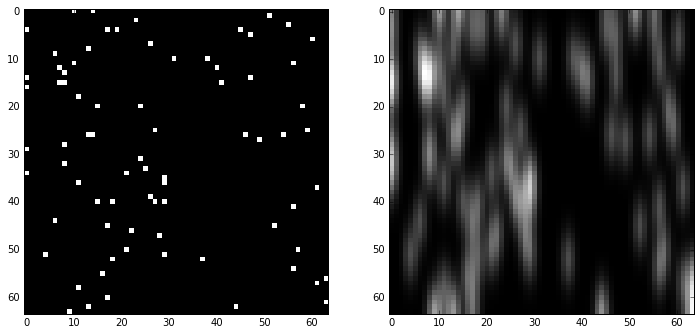

In [3]:
images = array(rand(10000, 64, 64) < 0.02, 'f')
filtered = array([ndi.gaussian_filter(image, (4.0, 1.0)) for image in images])
showrow(images[0], filtered[0], fs=(12,6))

- The Gaussian filter is a simple example of a _linear filter_.
- Linearity: $ W * (\alpha x + y) = \alpha W * x + W * y $

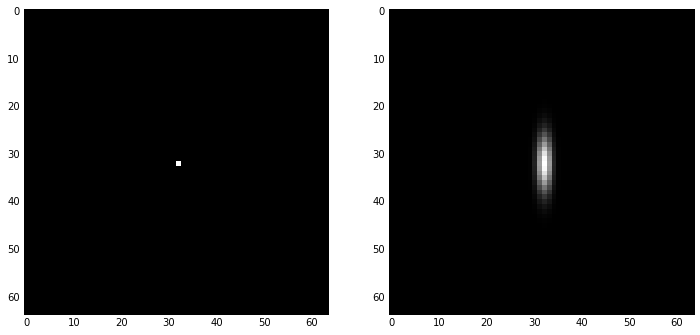

In [4]:
# impulse response
x = zeros((64, 64)); x[32, 32] = 1
y = ndi.gaussian_filter(x, (4.0, 1.0))
showrow(x, y, fs=(12,6))

Linear filters are completely characterized by their _impulse response_. Linearity + impulse response gives us the FIR representation of a filter.

There is a large and rich theory of linear filters in signal processing and image processing:

- mathematical properties: superposition, decomposition, impulse response
- frequency domain analysis
- optimal design for given tasks

NB: "optimal linear" is not the same as "optimal"

# Convolutional Layers

![chapter](chapter.png)

In [5]:
def make_model():
    return nn.Conv2d(1, 1, 15, padding=7)

Linear filters are implemented using convolutional layers.

These layers are the direct equivalent of a _Finite Impulse Response_ filter.

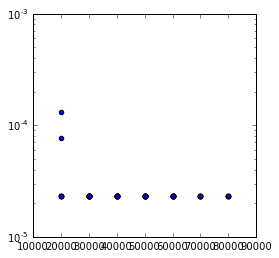

In [6]:
reload(imgimg)
amlp = imgimg.AutoMLP(make_model, Tim(images), Tim(filtered), initial_bs=100, maxtrain=100000, decay=1e-5)
filt = amlp.train()

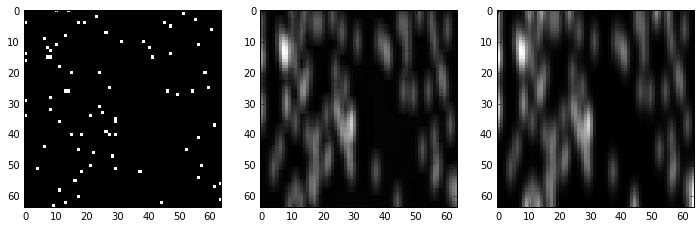

In [7]:
showrow(images[0], filt(Tim(images[:2]))[0].reshape(64, 64), filtered[0], fs=(12,6))

In [8]:
filt.weight.size()

torch.Size([1, 1, 15, 15])

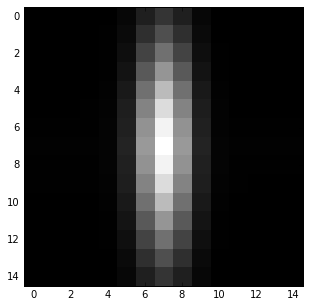

In [9]:
showrow(N(filt.weight[0,0]))

The weights learned by the linear layer are just the filter parameters of a classical FIR filter.

In [10]:
def make_model():
    return nn.Sequential(
        nn.Conv2d(1, 1, (15, 1), padding=(7, 0)),
        nn.Conv2d(1, 1, (1, 15), padding=(0, 7)))

_Separability_ is an important concept in FIR filters: instead of running a single large kernel, we run two one-dimensional kernels.

Separable filters/layers are faster and easier to learn and are commonly used in large DL vision models.

## Separable and Non-Separable Filters

Separable linear filters are a subset of non-separable linear filters.

Collections of separable filters/layers can approximate arbitrary filters/conv layers; you can precompute separable versions of filters using the SVD.

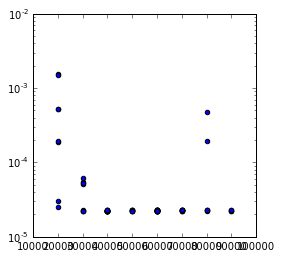

In [11]:
amlp = imgimg.AutoMLP(make_model, Tim(images), Tim(filtered), initial_bs=100, maxtrain=100000, decay=1e-5)
filt = amlp.train()

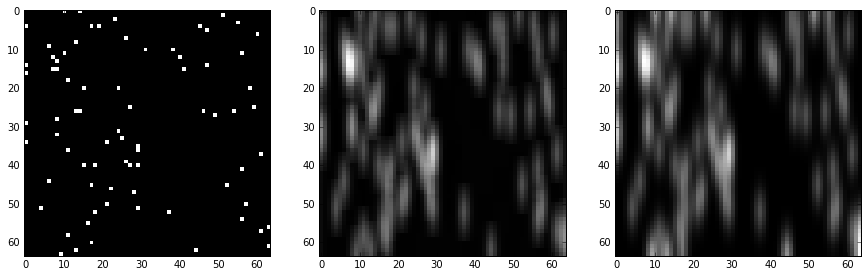

In [12]:
showrow(images[0], filt(Tim(images[:2]))[0].reshape(64, 64), filtered[0])

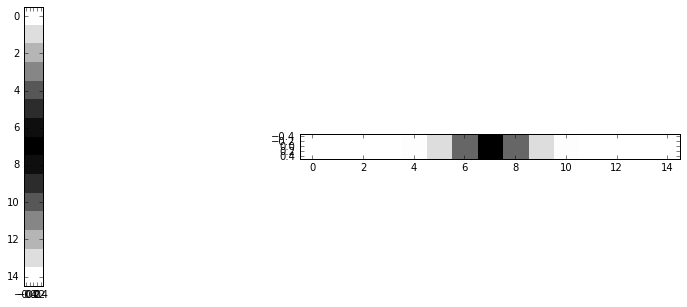

In [13]:
showrow(filt[0].weight, filt[1].weight)

![summary](sicon.png)

Convolutional layers are described by the same theory as linear filters.

The impulse response fully characterizes linear layers.

Separability is an important performance feature, both for linear filters and for DNNs.

# Convolutions as Fully Connected Layers

![chapter](chapter.png)

In [14]:
def make_model():
    return nn.Linear(64*64, 64*64)

Note that convolutional layers are just linear layers with tied weights and a special repetitive structure.

In fact, we can learn these layers directly.

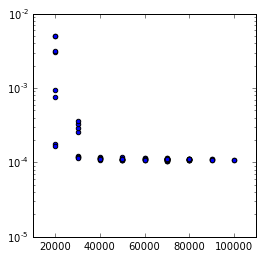

In [15]:
reload(imgimg)
amlp = imgimg.AutoMLP(make_model, Fl(images), Fl(filtered), initial_bs=100, maxtrain=100000, decay=1e-5)
filt = amlp.train()

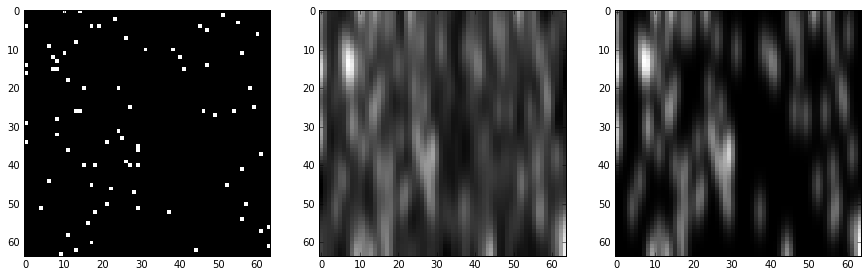

In [16]:
showrow(images[0], filt(Fl(images[:2]))[0].reshape(64, 64), filtered[0])

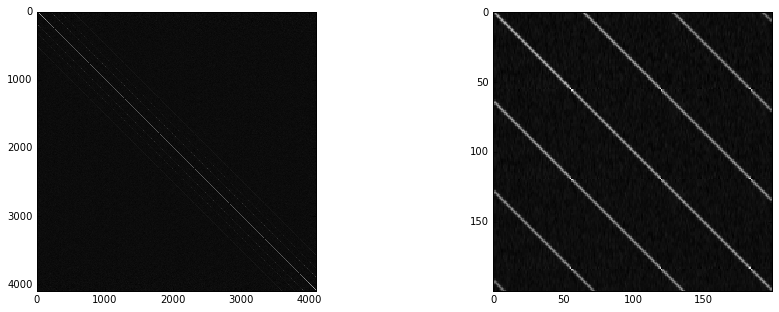

In [17]:
figsize(18, 9)
showrow(N(filt.weight), N(filt.weight[200:400,200:400]))

![summary](sicon.png)

Convolutional layers are really just a special case of fully connected linear layers.

The convolutional structure shows up as (1) weight tying, (2) sparsity, and (3) regularity.

# Color Space Transformation

![chapter](chapter.png)

In [18]:
db = h5py.File('/mdata/H5DATA/cifar10.h5')
images = np.array(db["images"])/255.0
import skimage, skimage.color
transformed = array([skimage.color.rgb2xyz(image) for image in images])

(50000, 32, 32, 3)


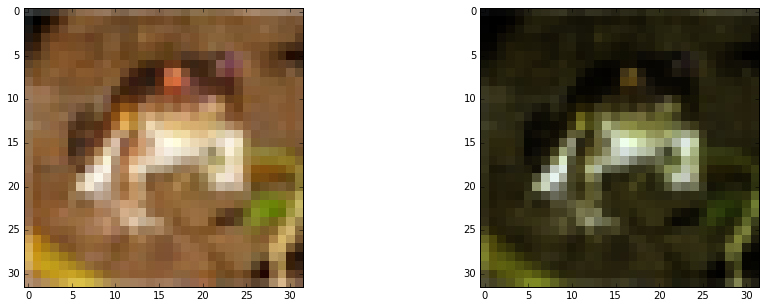

In [19]:
showrow(images[0], transformed[0])
print images.shape

Color space transformations are a common "convolutional"
operation in traditional image procesing.

Here: RGB to XYZ space transformation.

In [20]:
def make_model():
    return nn.Conv2d(3, 3, 1, padding=0)

A color space transformation is purely single pixel based.

We implement this using a 1x1 convolution. That is, for each pixel, $y = M \cdot x$.

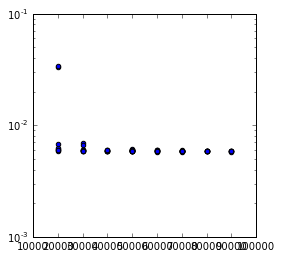

In [21]:
reload(imgimg)
figsize(8, 8)
amlp = imgimg.AutoMLP(make_model, Tim(images), Tim(transformed), initial_bs=100, maxtrain=100000, decay=1e-5)
xyz = amlp.train()

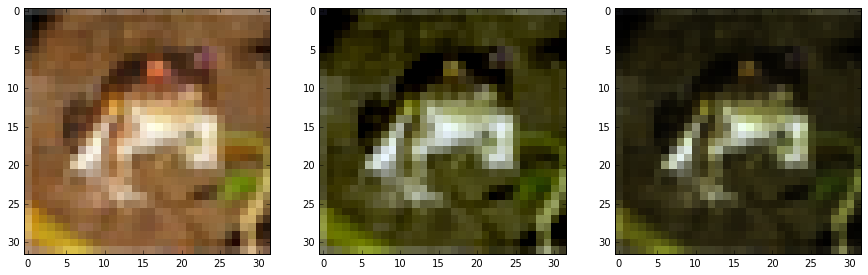

In [22]:
figsize(18, 6)
showrow(images[0], clip(Nim(xyz(Tim(images[:2])))[0], 0, 1), transformed[0])

In [23]:
xyz.weight[:,:,0,0]

tensor([[ 0.4111,  0.2460,  0.2540],
        [ 0.2433,  0.5448,  0.1735],
        [ 0.0093,  0.0488,  0.9676]], device='cuda:0')

In [24]:
array([[0.4887180,  0.3106803,  0.2006017], [0.1762044,  0.8129847,  0.0108109], [0.0000000,  0.0102048,  0.9897952]])

array([[0.488718 , 0.3106803, 0.2006017],
       [0.1762044, 0.8129847, 0.0108109],
       [0.       , 0.0102048, 0.9897952]])

# Network in Network

People often have the idea that running a nonlinear network "at each pixel" would be more powerful than convolutional layers. This is called "network-in-network".

A fully connected one hidden layer network is $z = \sigma(W_2 \cdot \sigma(W_1 \cdot x))$ (ignoring bias terms).

Running this at every pixel is simply equivalent to:

    nn.Sequential(
        nn.Conv2d(_, _, 1),
        nn.Sigmoid(),
        nn.Conv2d(_, _, 1),
        nn.Sigmoid())

![summary](sicon.png)

$1 \times 1$ convolutions are an important special case.

A prototypical classical example is color space transformations.

$1 \times 1$ convolutions are also a way of efficiently "running a network at every pixel".

# Bayer Pattern

![chapter](chapter.png)

As a non-trivial application of convolutional layers, something that people have invested a lot of time in developing manually, consider Bayer pattern conversion.

Digital cameras capture not RGB values, but spatially sampled RGB values, sampled according to the Bayer pattern.


In [25]:
def bayer(image):
    r, g, b = image+0, image+0, image+0
    r[:,:,1:] = 0; r[::2,:, :] = 0; r[:,::2, :] = 0
    g[:,:,0] = 0; g[:,:,2] = 0; g[::2,::2,:] = 0; g[1::2,1::2,:] = 0
    b[:,:,:2] = 0; b[1::2,:,:] = 0; b[:,1::2] = 0
    return r+g+b

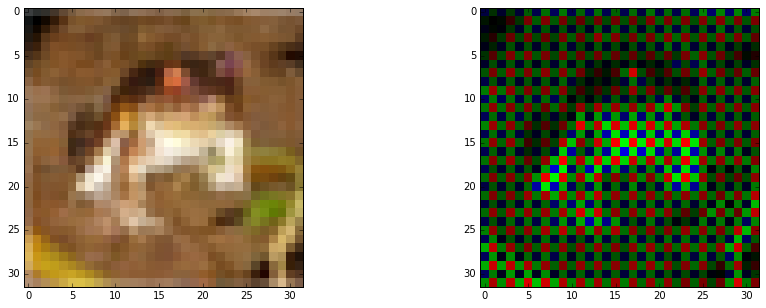

In [26]:
bayers = array([bayer(image) for image in images])
showrow(images[0], bayers[0])

In [27]:
def make_model():
    return nn.Conv2d(3, 3, 5, padding=2)

make_model().weight.shape

torch.Size([3, 3, 5, 5])

A linear model for Bayer pattern conversion is a collection of 9 filters combined linearly.

We can model this using a simple DL model and then train it.

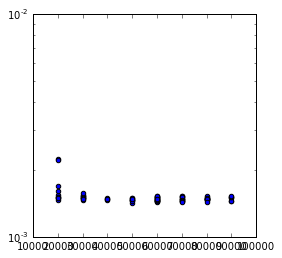

In [28]:
reload(imgimg)
figsize(8, 8)
amlp = imgimg.AutoMLP(make_model, Tim(bayers), Tim(images), initial_bs=20, maxtrain=100000, decay=1e-5)
baynet = amlp.train()

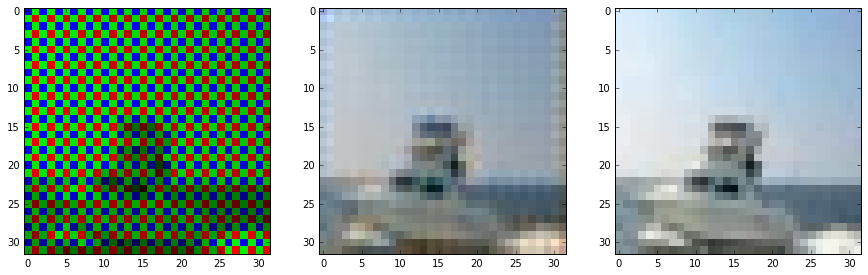

In [29]:
figsize(18, 6)
n=100
showrow(bayers[n], Nim(baynet(Tim(bayers[n:n+1])))[0], images[n])

In [30]:
def make_model():
    return nn.Sequential(
        nn.Conv2d(3, 64, 5, padding=2),
        nn.Sigmoid(),
        nn.Conv2d(64, 3, 5, padding=2))

We can also use deeper models to learn this conversion.

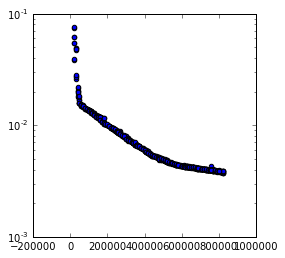

In [31]:
reload(imgimg)
amlp = imgimg.AutoMLP(make_model, Tim(bayers), Tim(images), initial_bs=200, maxtrain=1000000, decay=1e-5)
baynet = amlp.train()

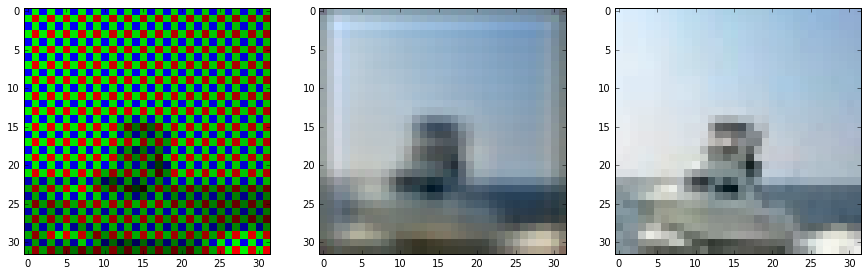

In [32]:
n=100
showrow(bayers[n], Nim(baynet(Tim(bayers[n:n+1])))[0], images[n])

Well-trained deeper models tend to give substantially better results than linear models
on Bayer pattern conversions. Reason?

The initial layers tend to "learn common patterns" in the image, which then get transformed as a whole.

In traditional image processing, this would have been accomplished using VQ methods and visual vocabulary mappings.

![summary](sicon.png)

Transforming Bayer patterns into images is an important example of several concepts:

- a domain where DNNs perform significantly better than traditional methods
- a domain where non-linear methods perform better for well-understood reasons
- an example of a convolution where we can understand how depth and spatial mixing interact

For training, it's an important example of _inverse learning_ on artificially generated data.

# Communications Channel

![chapter](chapter.png)

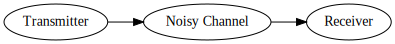

In [33]:
Source("""digraph G{ rankdir=LR; Transmitter -> "Noisy Channel" -> Receiver }""")

Much of traditional signal processing and information theory is concerned with _noisy communications channels_:

- a signal with a known distribution is transmitted by a transmitter
- it passes through a noisy channel
- it is received by a receiver
- the receiver tries to reconstruct the original signal

# Channel Models

Common channel model: $y = W * x + \nu$

Used in...

- telephony (filtering by network, electric noise)
- audio/video coding (filtering by analogy circuit, physical noise)
- speech (signal is abstract phoneme sequence, encoding+filtering+coding is brain/sound)
- computer vision (signal is ideal 3D surfaces, encoding+filtering+coding is reflection/noise/sensor)

Usual task: _recover source from received, noisy signal_

In [34]:
# Let's start with MNIST data
def load_images(images):
    images = images.reshape(-1, 1, 28, 28)
    cuimages = torch.FloatTensor(images).cuda()
    return images, cuimages
db = h5py.File('/mdata/H5DATA/mnist.h5')
images = array(db["images"])
classes = array(db["labels"])
test_images = array(db["test_images"])
test_classes = array(db["test_labels"])

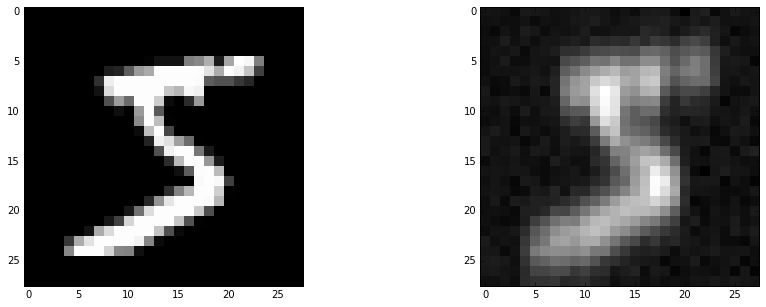

In [35]:
degraded = array([ndi.gaussian_filter(image, (2.0, 0.5))+0.02*randn(28, 28) for image in images])
showrow(images[0], degraded[0])

In [36]:
def make_model():
    return nn.Conv2d(1, 1, 11, padding=5)

Let's start off with a linear model for recovering the original signal.

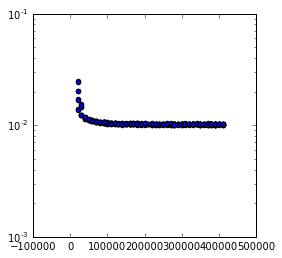

In [37]:
reload(imgimg)
figsize(8, 8)
amlp = imgimg.AutoMLP(make_model, Tim(degraded), Tim(images), initial_bs=200, maxtrain=500000, decay=1e-5)
invnet = amlp.train()

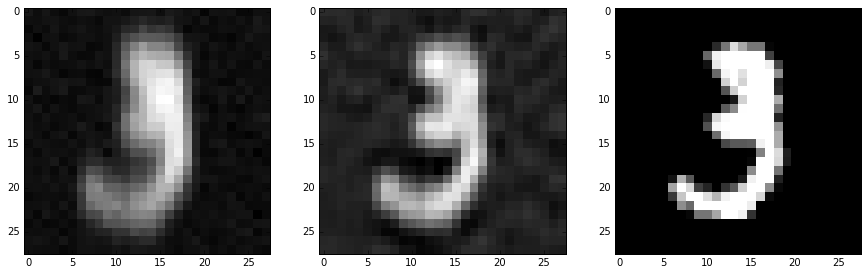

In [38]:
n=10
showrow(degraded[n], Nim(invnet(Tim(degraded[n:n+1])))[0], images[n])

This shows an "optimal" linear inverse channel model.

The linear filter tries to strike a balance between sharpening edges and suppresing noise, but solves neither task all that well.

In [39]:
def make_model():
    return nn.Sequential(
        nn.Conv2d(1, 64, 11, padding=5),
        nn.Sigmoid(),
        nn.Conv2d(64, 1, 11, padding=5))

Let's try a simple non-linear model instead.

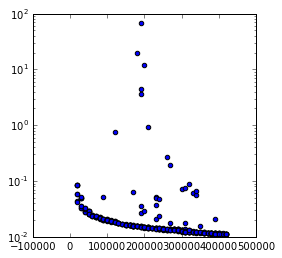

In [40]:
reload(imgimg)
figsize(8, 8)
amlp = imgimg.AutoMLP(make_model, Tim(degraded), Tim(images), initial_bs=200, maxtrain=500000, decay=1e-5)
invnetnl = amlp.train()

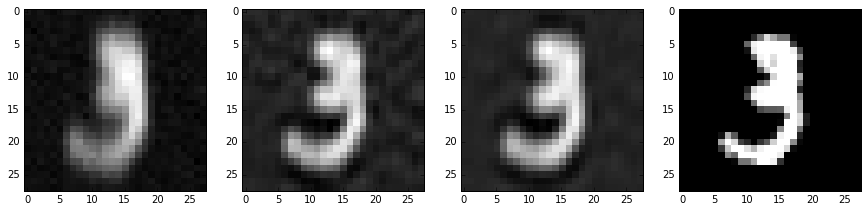

In [41]:
showrow(degraded[n], Nim(invnet(Tim(degraded[n:n+1])))[0], Nim(invnetnl(Tim(degraded[n:n+1])))[0], images[n])

## Why is this still fuzzy?

Would more training data elimiate the fuzziness from the output of the network?

No. The reason is that the network estimates per-pixel posterior probabilities.

The fuzziness represents the "Bayes error".

In order to get sharp output, we need to sample from the posterior distribution. This can be done by GANs.

![summary](sicon.png)

Channel models and inverting a channel are common applications and a common framework for machine learning and DNNs.

Forward channel models can often be characterized or learned.

Inverse channel models can be derived mathematically in the linear case.

Nonlinear inverses generally do significantly better.

# Other Uses of Linear Filters

![chapter](chapter.png)

In [46]:
def sigmoid(x): return 1/(1+exp(-x))

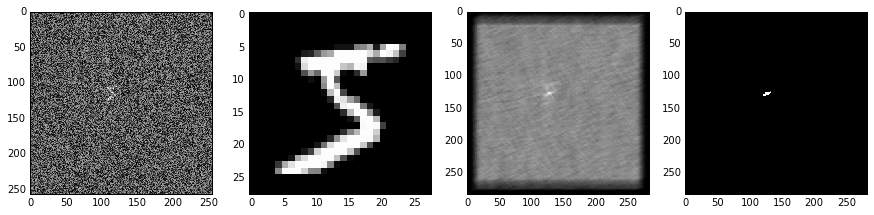

In [53]:
from scipy import signal
image = rand(256, 256)
image[100:128, 100:128] += images[0]*0.5
cor = signal.correlate2d(image, images[0])
thresholded = sigmoid(10.0*(cor-0.7*amax(cor)))
showrow(image, images[0], cor, thresholded)

Linear filters are traditionally used for object detection via matched filters.

They work very well for this purpose in some applications, but not in general vision/object recognition tasks.

However, "feature extraction" in DL networks can be understood as "matched filters".

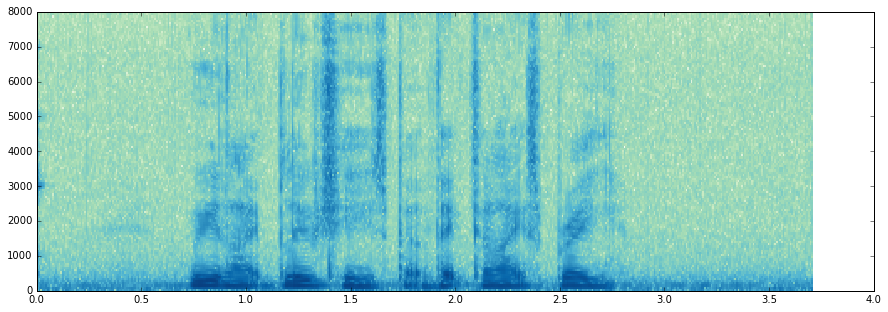

In [54]:
wave = numpy.fromfile("msak0_306.raw", "int16")
specgram(wave, Fs=16000, cmap=cm.GnBu);

Linear filters and filter banks are also widely used for _frequency domain analysis_.

Here in speech, you see a "windowed Fourier transform". Such transforms consist of localized sinusoidal filters. A large set of such filters is referred to as a "Gabor jet".

There is a rich theory of these kinds of filters, and related techniques such as wavelet analysis.

# Frequency Sensitive Filters in DL

**emergence based on task** If a task benefits from frequency selective filters, convolutional input layers may directly learn such filters. There is some evidence for such filters in the human visual system.

**explicit windowed FFT** Some tasks (e.g., speech recognition) explicity use frequency domain techniques for preprocessing. Since FFTs are much faster than convolutional layers, this speeds up overall processing and also helps networks learn faster.

**backprop through FFT** An FFT is just a linear transformation of the input (a rotation even), so we can just put it directly into a DL pipeline.



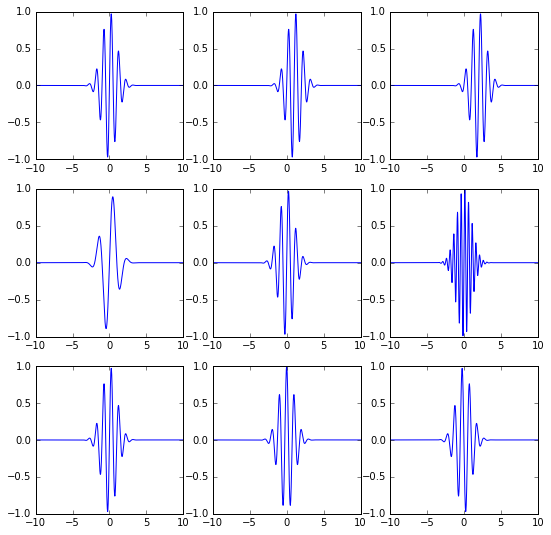

In [55]:
# 1D localized frequency filters
figsize(9,9)
xs = linspace(-10, 10, 1000)
def filter(x, mu=0, sigma=1.0, freq=1.0, phase=0.0):
    return exp(-(x-mu)**2/(2*sigma**2)) * sin(2*pi*(x*freq+phase))
for i, kw in enumerate([dict(), dict(mu=1), dict(mu=2), dict(freq=0.5), dict(freq=1), dict(freq=2), dict(), dict(phase=0.25), dict(phase=0.5)]):
    subplot(3, 3, i+1); plot(xs, filter(xs, **kw))

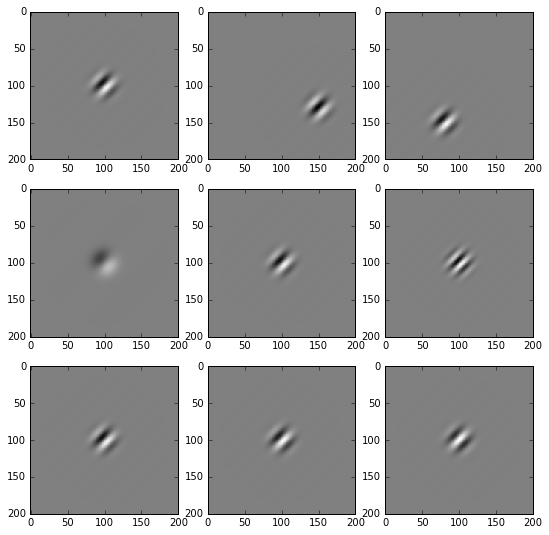

In [56]:
# 2D localized frequency filters
figsize(9,9)
xs, ys = meshgrid(linspace(-10, 10, 200), linspace(-10, 10, 200))
def filter(xs, ys, mu=(0,0), sigma=1.0, freq=(0.7, 0.7), phase=0.0):
    mu = array(mu)
    r = tensordot(freq, array([xs, ys]), axes=1)
    rs = sum((array([xs, ys]) - mu[:, newaxis, newaxis])**2, axis=0)
    return exp(-rs/(2*sigma**2)) * sin(0.5*2*pi*(r+phase))
for i, kw in enumerate([dict(), dict(mu=(5.0, 3.0)), dict(mu=(-2.0, 5.0)), 
                        dict(freq=(0.2, 0.2)), dict(freq=(0.7, 0.7)), dict(freq=(1.0, 1.0)), 
                        dict(), dict(phase=0.25), dict(phase=0.5)]):
    subplot(3, 3, i+1); imshow(filter(xs, ys, **kw), vmin=-1, vmax=1)

In [57]:
def make_model():
    return nn.Sequential(
        nn.Conv2d(1, 64, 11, padding=5),
        nn.Sigmoid(),
        nn.Conv2d(64, 1, 11, padding=5))

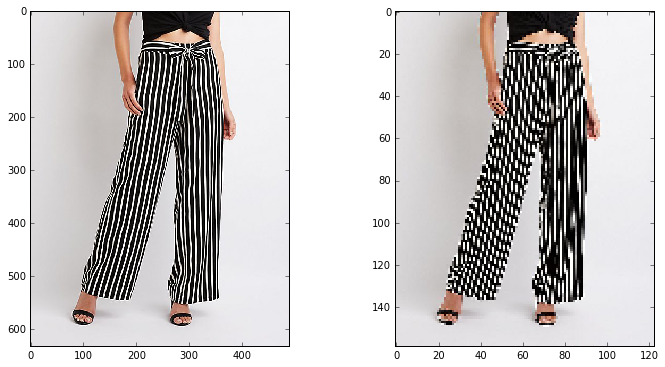

In [58]:
# aliasing
texture = imread("texture7.jpg")
figsize(12,6)
subplot(121); imshow(texture); subplot(122); imshow(texture[::4,::4])

Sampling theory also tells us how and why imaging artifacts like aliasing appear.
These kinds of artifacts occur in many forms of GAN.

![summary](sicon.png)

Linear filters correspond directly to convolutional layers.

Color space transformations correspond to $1\times1$ convolutional layers.

Convolutional layers are a special case of fully connected linear layers, with a particular pattern of weight tying.

Convolutional layers can be viewed as a kind of "network-in-network": applying a network around each pixel.

Special kinds of linear filters are still useful with DL (e.g., windowed Fourier transform).

There is a rich theory of linear filters: impulse response, frequency domain analysis, communications and detection theory, etc.



# Shape Discrimination

![chapter](chapter.png)

In [59]:
import cv2
def genimage(c):
    s = 128
    image = zeros((s, s))
    if c:
        x, y = randint(20, s-20), randint(20, s-20)
        r = randint(5, 15)
        cv2.circle(image, (x, y), r, 255, 1)
    else:
        x, y = randint(20, s-20), randint(20, s-20)
        r1, r2 = randint(8, 12), randint(8, 12)
        cv2.rectangle(image, (x-r1, y-r2), (x+r1, y+r2), 255, 1)
    image = ndi.gaussian_filter(image, 1.0)
    image /= amax(image)
    image += 0.05 * randn(*image.shape)
    return image
classes = array(rand(10000) > 0.5, 'i')
images = array([genimage(c) for c in classes])
test_classes = array(rand(1000) > 0.5, 'i')
test_images = array([genimage(c) for c in test_classes])

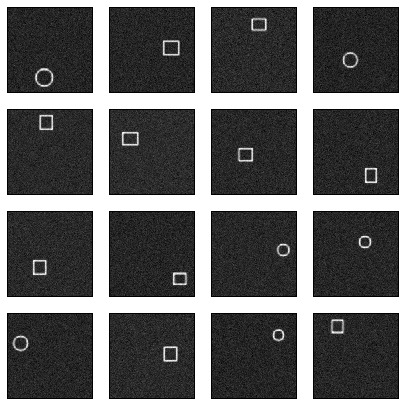

In [60]:
figsize(8, 8)
showgrid(images)

The discrimination task is very simple: circles vs square. A DL model should be able to handle that.

In [61]:
def block(nin, nout):
    return [
        nn.Conv2d(nin, nout, 3, padding=1),
        nn.BatchNorm2d(nout),
        nn.ReLU(),
        nn.MaxPool2d(2, 2)]

def make_model():
    model = block(1, 8) + block(8, 16) + block(16, 32) + \
        [layers.Flat(), nn.Linear(32*16*16, 100), 
         nn.BatchNorm1d(100), nn.ReLU(), nn.Linear(100, 10)]
    return nn.Sequential(*model)

Let's use a standard VGG-like model, consisting of a number of convolution + maxpool blocks, followed by a couple of fully connected layers.

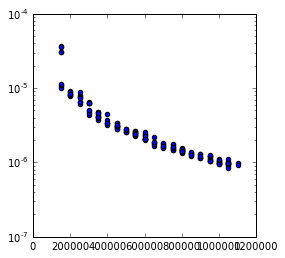

#best 0.0 @ 100000 of 1050000


Sequential(
  (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Flat
  (13): Linear(in_features=8192, out_features=100, bias=True)
  (14): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (15): ReLU()
  (16): Linear(in_features=100, out_feature

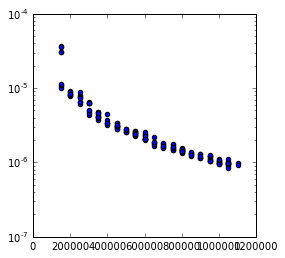

In [62]:
reload(imgclass)
amlp = imgclass.AutoMLP(make_model, Tim(images), Cl(classes), Tim(test_images), Cl(test_classes),
                        initial_bs=200, maxtrain=1000000)
net = amlp.train(); clf()
net.cuda()

We get zero test set error rate.

In [63]:
import cv2
def genimage(c):
    s = 128
    image = zeros((s, s))
    if c:
        x, y = randint(20, s-20), randint(20, s-20)
        while 1:
            r1, r2 = randint(8, 12), randint(8, 12)
            if abs(r1-r2)>=2: break
        cv2.rectangle(image, (x-r1, y-r2), (x+r1, y+r2), 255, 1)
    else:
        x, y = randint(20, s-20), randint(20, s-20)
        r1 = randint(8, 12); r2 = r1
        cv2.rectangle(image, (x-r1, y-r2), (x+r1, y+r2), 255, 1)
    image = ndi.gaussian_filter(image, 1.0)
    image /= amax(image)
    image += 0.05 * randn(*image.shape)
    return image
classes = array(rand(10000) > 0.5, 'i')
images = array([genimage(c) for c in classes])
test_classes = array(rand(1000) > 0.5, 'i')
test_images = array([genimage(c) for c in test_classes])

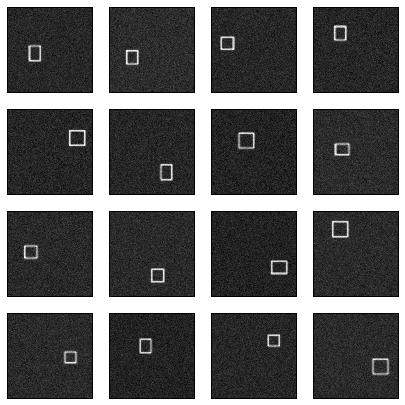

In [64]:
showgrid(images)

Let's try a slightly different tasks: rectangles vs square. How does the same model perform?

In [ ]:
print images.shape
print classes.shape

amlp = imgclass.AutoMLP(make_model, Tim(images), Cl(classes), Tim(test_images), Cl(test_classes),
                        initial_bs=200, maxtrain=1000000)
net = amlp.train(); clf()
net.cuda()

That's hardly better than chance!

# Convolutional Layers

Blocks of the form:

        nn.Conv2d(nin, nout, 3, padding=1),
        nn.BatchNorm2d(nout),
        nn.ReLU(),
        nn.MaxPool2d(2, 2)
        
appear frequently in DL networks.

They are great for some forms of object recognition.

They fail to be able to discriminate certain common classes of objects because the convolutions simply can't capture the relevant object properties.

# Topological Relationships

![chapter](chapter.png)

In [96]:
def  blobs():
    image = rand(128, 128)
    image = (image < 0.1).astype('f')
    image = ndi.gaussian_filter(image, 15.0, mode='constant')
    image = (image > percentile(image, 70)).astype('f')
    return image

def boundary(image):
    interior = ndi.minimum_filter(image, 3)
    return ((image - interior) > 0.5).astype('f')

def addnoise(image):
    image = image + 0.01*randn(*image.shape)
    image -= amin(image)
    image /= amax(image)
    return image

images = array([blobs() for _ in xrange(10000)])
boundaries = array([boundary(image) for image in images])
images = array(map(addnoise, images))
boundaries = array(map(addnoise, boundaries))

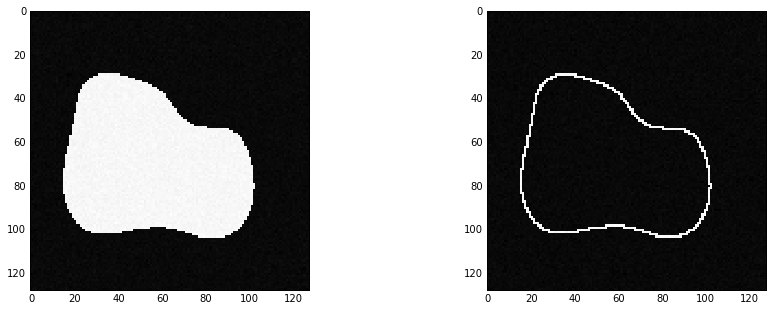

In [97]:
blob = blobs()
showrow(addnoise(blob), addnoise(boundary(blob)))

Let's learn simple topological relationships, here inside/outside relationships.

We can formulate this as a classification problem ("is the shape filled"), but it's easier to understand if we formulate this as an image-to-image transformation problem.

In [98]:
d = 16
r = 7
def make_model():
    return nn.Sequential(
        nn.Conv2d(1, d, r, padding=(r-1)//2),
        nn.BatchNorm2d(d),
        nn.ReLU(),
        nn.Conv2d(d, 1, 1),
        nn.BatchNorm2d(1),
        nn.Sigmoid())

Our model is a fairly simple convolutional model with one hidden layer.

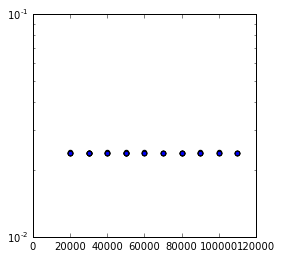

In [99]:
reload(imgimg)
amlp = imgimg.AutoMLP(make_model, Tim(images), Tim(boundaries), initial_bs=200, maxtrain=100000, decay=1e-5)
boundarynet = amlp.train()

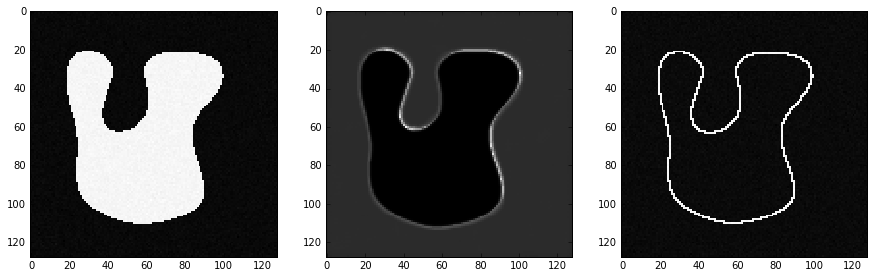

In [100]:
n = 100
showrow(images[n], Nim(boundarynet(Tim(images[n:n+1])))[0], boundaries[n])

Learning to go from filled shapes to their boundaris is easy.

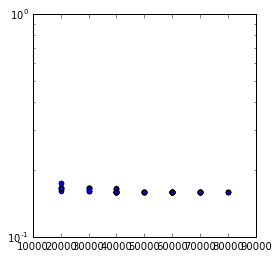

In [101]:
reload(imgimg)
amlp = imgimg.AutoMLP(make_model, Tim(boundaries), Tim(images), initial_bs=200, maxtrain=100000, decay=1e-5)
rboundarynet = amlp.train()

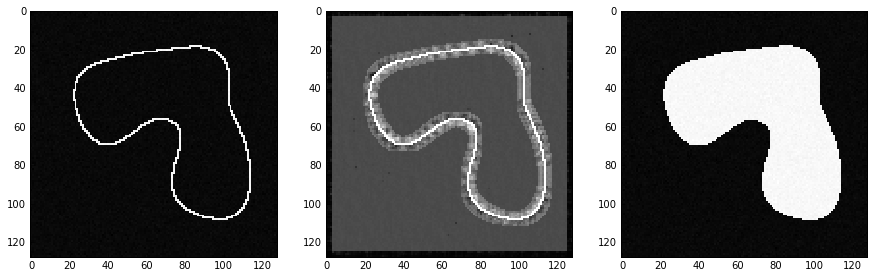

In [102]:
n = 200
showrow(boundaries[n], Nim(rboundarynet(Tim(boundaries[n:n+1])))[0], images[n], vmin=0, vmax=1)

The other direction fails with simple convolutional layers.

![summary](sicon.png)

There are a number of problems that are not well addressd by linear filters/convolutional layers, even when paired with max pooling.

Examples are geometric relationships and topological features.

# Nonlinear Filters

![chapter](chapter.png)

# Nonlinear Filters

We've seen examples of learning linear filters and related problems.

Linear filters map nicely onto convolutional layers and have great theoretical foundations and justifications.

Many problems involve non-linear filters: local maximum, mathematical morphology, rank filtering, etc.

Can we learn these?

What properties do they have?

Examples of non-linear filters:

- local maximum/minimum
- median/percentile
- mathematical morphology
- thresholding


Examples of nonlinear filters from DL itself:

- nonlinearities `nn.Sigmoid`, `nn.ReLU`
- pooling `nn.MaxPool2d`

The DL nonlinear filters have themselves been made learnable.

# DL Nonlinearities

In [103]:
def t(x): return torch.FloatTensor(x)
def n(x): return x.detach().numpy()

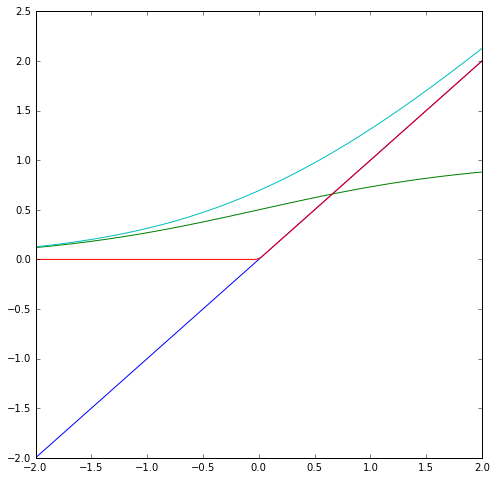

In [104]:
# comparison of nonlinearities
figsize(8,8)
xs = linspace(-2, 2, 100)
plot(xs, xs)
plot(xs, n(nn.Sigmoid()(t(xs))))
plot(xs, n(nn.ReLU()(t(xs))))
plot(xs, n(nn.Softplus()(t(xs))))

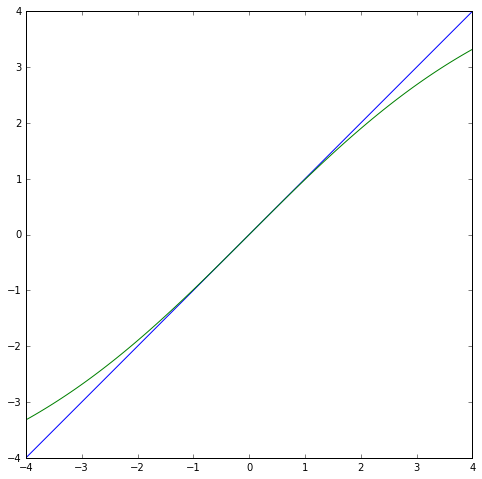

In [105]:
# approximating linearities with sigmoid
figsize(8,8)
xs = linspace(-4, 4, 100)
plot(xs, xs)
plot(xs, n(10*(nn.Sigmoid()(t(0.4*xs))-0.5)))

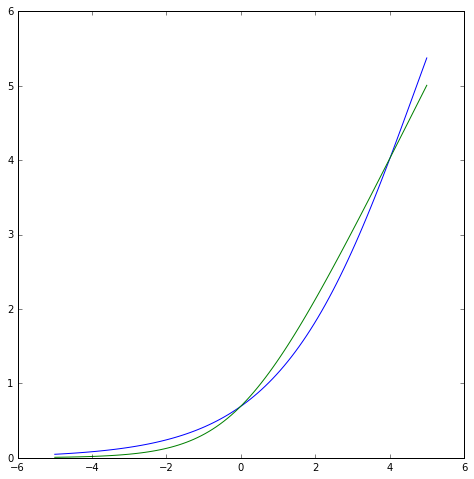

In [106]:
# approximation of softplus with sigmoid
figsize(8,8)
xs = linspace(-5, 5, 100)
plot(xs, 10*n(nn.Sigmoid()(0.55*t(xs)-2.6)))
plot(xs, n(nn.Softplus()(t(xs))))

In [107]:
db = h5py.File('/mdata/H5DATA/cifar10.h5')
images = mean(np.array(db["images"])/255.0, 3)
print images.shape
filtered = array([ndi.median_filter(image, (4, 4)) for image in images])

(50000, 32, 32)


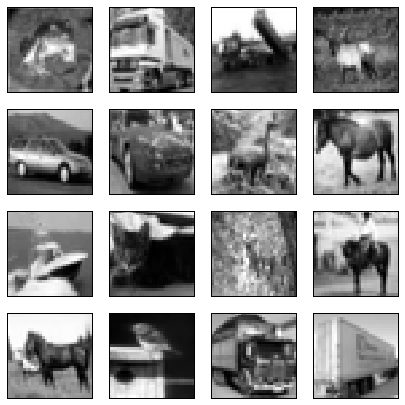

In [108]:
showgrid(images)

We use grayscale images for training.

(50000, 32, 32) (50000, 32, 32)


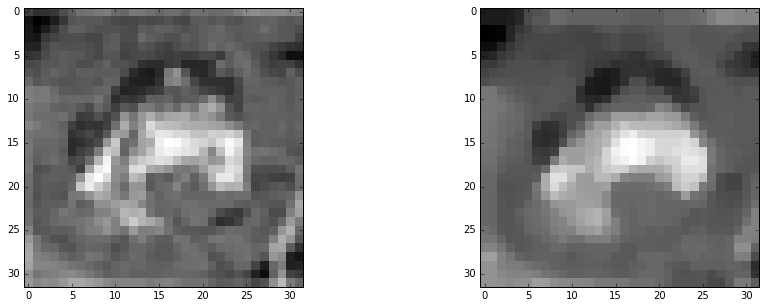

In [109]:
showrow(images[0], filtered[0])
print images.shape, filtered.shape

Input image on left, median filtered output on the right.

In [110]:
def make_model():
    return nn.Sequential(
        nn.Conv2d(1, 16, (15, 1), padding=(7, 0)),
        nn.Conv2d(16, 32, (1, 15), padding=(0, 7)),
        nn.Sigmoid(),
        nn.Conv2d(32, 1, 1),
        nn.Sigmoid())

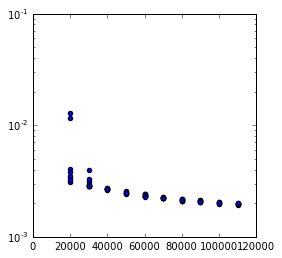

In [111]:
amlp = imgimg.AutoMLP(make_model, Tim(images), Tim(filtered), initial_bs=100, maxtrain=100000, decay=1e-5)
filt = amlp.train()

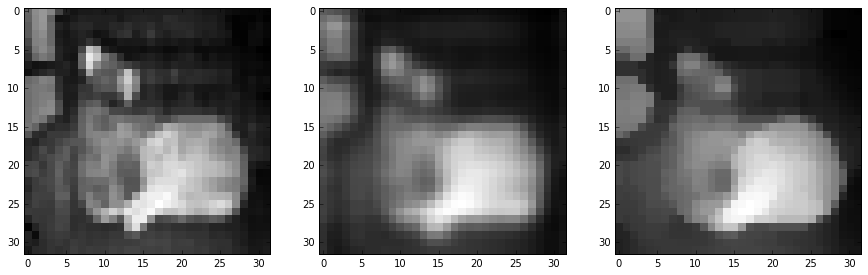

In [112]:
n=17
showrow(images[n], Nim(filt(Tim(images[n:n+1])))[0], filtered[n], vmin=0, vmax=1)

The network returns a pretty good approximation to the median filter
(albeit with a bit more blurring.)

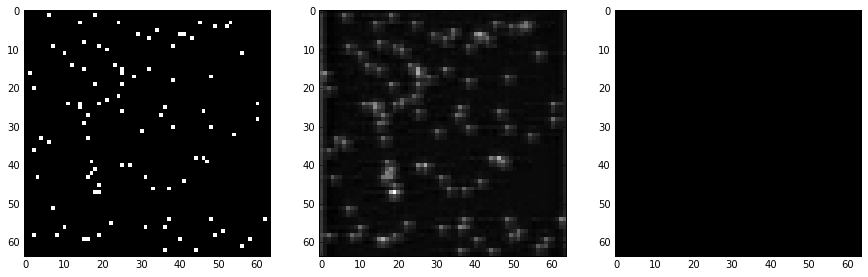

In [113]:
bits = array(rand(64, 64) < 0.02, 'f')
output = Nim(filt(Tim(bits.reshape(1,64,64,1))))
fbits = ndi.median_filter(bits, (4, 4))
subplot(131); imshow(bits); subplot(132); imshow(output[0,:,:,0]); subplot(133); imshow(fbits)

But... the "learned median filter" does not generalize to new image types:
    
- the median filter of isolated dots is an empty image
- yet the output from the learned filter is non-zero

💡 Learned nonlinear filters are dependent on input distributions.

![](sicon.png)

Nonlinear filters are learnable using DL techniques.

This results in an approximation of the nonlinear filter as a collection of linear filters, nonlinearities, pooling, and other DL operations.

Such approximations tend to be _distribution dependent_, meaning that if you apply them to other kinds of inputs, they fail to be good approximations.

# IIR Filters and their DL Equivalents

![](chapter.png)

In [114]:
# simple IIR filter

def simple_iir(xs):
    value = xs[0]
    output = zeros(len(xs))
    for i in range(len(xs)):
        output[i] = value
        value = 0.7 * value + 0.3 * xs[i]
    return output

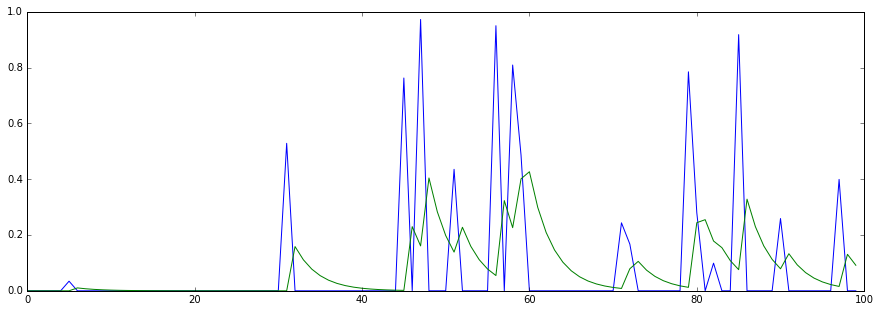

In [115]:
xs = rand(100) * (rand(100) < 0.1)
plot(xs)
plot(simple_iir(xs))

# IIR Filters

IIR filters are simple linear filters.

Unlike FIR filters, the output is a linear function of both inputs and past output values.

IIR filters can approximate FIR filters well.

IIR filters are the linear equivalent of _recurrent neural networks_.

# 1D IIR Filters

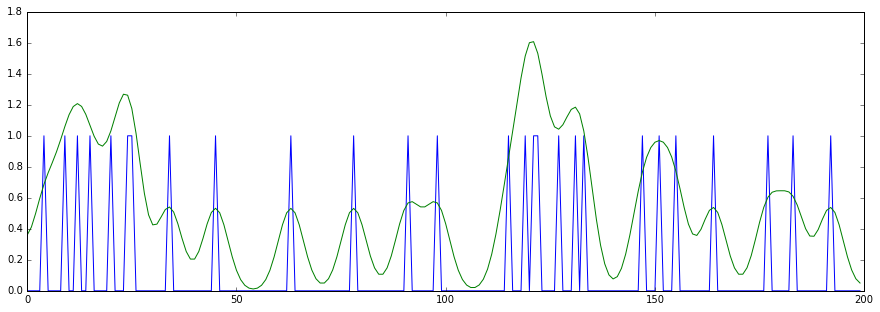

In [116]:
inputs = array([(rand(200) < 0.1).astype('f') for i in range(10000)]).reshape(-1, 1, 200)
outputs = array([4.0*ndi.gaussian_filter(s, 3.0) for s in inputs]).reshape(-1, 1, 200)
plot(inputs[0,0]); plot(outputs[0,0])

In [117]:
class SeqLSTM(nn.Module):
    def __init__(self, ninput, nhidden, nlayers=1, bidirectional=True):
        nn.Module.__init__(self)
        self.ninput = ninput
        self.nhidden = nhidden
        self.nlayers = nlayers
        self.bidirectional = bidirectional
        self.lstm = nn.LSTM(input_size=ninput, hidden_size=nhidden,
                            num_layers=nlayers, bidirectional=bidirectional)
        self.lstm.flatten_parameters()
    def forward(self, batch):
        b, d, l = batch.size()
        seq = batch.permute(2, 0, 1).contiguous() # LBD
        h0 = torch.zeros((1+self.bidirectional)*self.nlayers, b, self.nhidden).to(batch.device)
        c0 = torch.zeros((1+self.bidirectional)*self.nlayers, b, self.nhidden).to(batch.device)
        y, hn = self.lstm(seq, (h0, c0))
        return y.permute(1, 2, 0).contiguous() # LBD -> BDL

In [118]:
def train(model, targets, sequences, ntrain=100000, bs=20, lr=0.1, momentum=0.9, decay=0.0):
    assert sequences.dtype == torch.float
    assert len(sequences.shape) == 3
    assert targets.dtype == torch.float
    assert len(sequences.shape) == 3
    with torch.no_grad():
        model.forward(sequences[:bs].type(torch.float))
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=decay)
    losses = []
    for i in range(ntrain//bs):
        with torch.set_grad_enabled(True):
            optimizer.zero_grad()
            start = randint(0, len(sequences)-bs)
            inputs = sequences[start:start+bs]
            #print start, bs, sequences.shape, inputs.shape
            outputs = model.forward(inputs)
            loss = criterion(outputs, targets[start:start+bs].type(torch.float))
            losses.append(float(loss))
            loss.backward()
            optimizer.step()
    return losses

In [119]:
def make_model(): 
    return nn.Sequential(SeqLSTM(1, 4), nn.Sigmoid(), nn.Conv1d(8, 1, 1)).cuda()

The LSTM model we use for emulating an IIR is a...

- bidirectional model
- multidimensional hidden states ("number of taps")
- NB: #taps corresponds to FIR filter footprint

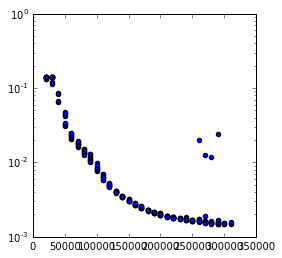

In [ ]:
reload(imgimg)
amlp = imgimg.AutoMLP(make_model, T(inputs), T(outputs), initial_bs=200)
iirlike = amlp.train()

In [ ]:
iirlike = amlp.population[0]
pred = iirlike(T(inputs))
plot(inputs[0,0])
with torch.no_grad(): plot(N(pred[0,0]), linewidth=2, color="green")
plot(outputs[0,0], linewidth=8, alpha=0.3, color="red")

In [ ]:
class RowwiseLstm(nn.Module):
    def __init__(self, ninput, nhidden, nlayers=1, bidirectional=False):
        nn.Module.__init__(self)
        self.ninput = ninput
        self.nhidden = nhidden
        self.nlayers = nlayers
        self.bidirectional = bidirectional
        self.lstm = nn.LSTM(input_size=ninput, hidden_size=nhidden, num_layers=nlayers, bidirectional=bidirectional)
        self.lstm.flatten_parameters()
    def forward(self, batch):
        b, d, h, w = batch.size()
        seq = batch.permute(3, 0, 2, 1).contiguous().view(w, b*h, d).contiguous()
        l, b1, d = seq.size()
        h0 = torch.zeros((1+self.bidirectional)*self.nlayers, b1, self.nhidden).to(batch.device)
        c0 = torch.zeros((1+self.bidirectional)*self.nlayers, b1, self.nhidden).to(batch.device)
        y, hn = self.lstm(seq, (h0, c0))
        return y.view(w, b, h, (1+self.bidirectional)*self.nhidden).permute(1, 3, 2, 0).contiguous()
class LSTM2(nn.Module):
    def __init__(self, ninput, nhidden, noutput=-1, footprint=1, nlayers=1, bidirectional=True):
        nn.Module.__init__(self)
        self.bidirectional = bidirectional
        self.wlstm = RowwiseLstm(ninput, nhidden, nlayers=nlayers, bidirectional=bidirectional)
        self.hlstm = RowwiseLstm((1+bidirectional)*nhidden, nhidden, nlayers=nlayers, bidirectional=bidirectional)
        self.conv = None
        if noutput > 0:
            self.conv = nn.Conv2D((1+bidirectional)*nhidden, noutput, footprint)
    def forward(self, batch):
        y = self.wlstm(batch)
        y = y.permute(0, 1, 3, 2)
        z = self.hlstm(y)
        z = z.permute(0, 1, 3, 2)
        if self.conv is not None:
            z = self.conv(z)
        return z

In [ ]:
images = array(rand(10000, 64, 64) < 0.02, 'f')
filtered = array([ndi.gaussian_filter(image, (8.0, 3.0)) for image in images])
showrow(images[0], filtered[0], fs=(12,6))

In [ ]:
def make_model():
    return nn.Sequential(
        LSTM2(1, 8),
        nn.Conv2d(16, 1, 1))

In [ ]:
reload(imgimg)
amlp = imgimg.AutoMLP(make_model, Tim(images), Tim(filtered), initial_bs=10, maxtrain=1000000, decay=1e-5)
filt = amlp.train()

In [ ]:
filt = amlp.population[0].cuda()
pred = Nim(filt(Tim(images[:10])))
showrow(images[0], pred[0], filtered[0], fs=(12,6))